
# Step 1: Project Setup and Data Acquisition

[*********************100%***********************]  1 of 1 completed

--- S&P 500 (SPY) Historical Data ---
Price        Adj Close       Close        High         Low        Open  \
Ticker             SPY         SPY         SPY         SPY         SPY   
Date                                                                     
2018-12-21  217.711227  240.699997  249.710007  239.979996  246.740005   
2018-12-24  211.958618  234.339996  240.839996  234.270004  239.039993   
2018-12-26  222.667786  246.179993  246.179993  233.759995  235.970001   
2018-12-27  224.377350  248.070007  248.289993  238.960007  242.570007   
2018-12-28  224.087860  247.750000  251.399994  246.449997  249.580002   

Price          Volume  
Ticker            SPY  
Date                   
2018-12-21  255345600  
2018-12-24  147311600  
2018-12-26  218485400  
2018-12-27  186267300  
2018-12-28  153100200  


<Figure size 1200x600 with 0 Axes>

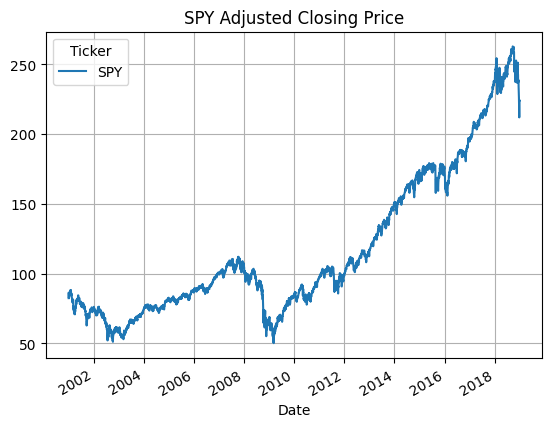

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Acquisition ---
# Define the ticker symbol for the S&P 500 ETF and the date range
ticker = "SPY"
start_date = "2001-01-01"
end_date = "2018-12-31"

# Fetch the data using yfinance
data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)

print("--- S&P 500 (SPY) Historical Data ---")
print(data.tail())

# Plot the closing price to visualize the data
plt.figure(figsize=(12, 6))
data['Adj Close'].plot(title='SPY Adjusted Closing Price')
plt.grid(True)
plt.show()


# Step 2: Feature Engineering

In [2]:
def create_features(data, lags=5):
    """
    Creates a pandas DataFrame with lagged returns and the target variable.
    """
    df = pd.DataFrame(index=data.index)
    df['Today'] = data['Adj Close']
    df['Volume'] = data['Volume']

    # Create the lagged percentage returns
    for i in range(1, lags + 1):
        # Corrected feature calculation
        df[f'Lag_{i}'] = data['Adj Close'].pct_change(i).shift(i) * 100

    # Create the target variable: Direction (+1 for up, -1 for down)
    df['Direction'] = np.sign(df['Today'].pct_change())

    df = df[df['Direction'] != 0]

    # Clean up the data
    df = df.dropna()
    df = df[~df.isin([np.inf, -np.inf]).any(axis=1)]

    return df

# Create features with 5 lags
features = create_features(data, lags=5)
print("\n--- Features for Forecasting ---")
print(features.head())


--- Features for Forecasting ---
                Today   Volume     Lag_1     Lag_2     Lag_3     Lag_4  \
Date                                                                     
2001-01-17  85.438972  7851400  0.639179 -0.094614  1.584274 -1.064701   
2001-01-18  86.289223  8107000  0.458757  0.448895  1.660615  2.370601   
2001-01-19  85.799080  7782500  0.995155  1.100868  0.543960  1.392204   
2001-01-22  86.369293  7050900 -0.568023  1.458477  0.909711  2.310408   
2001-01-23  87.049515  8463100  0.664591  0.421479  2.106978  1.005213   

               Lag_5  Direction  
Date                             
2001-01-17  0.800621        1.0  
2001-01-18 -2.129627        1.0  
2001-01-19 -0.971068       -1.0  
2001-01-22  2.177044        1.0  
2001-01-23  2.040281        1.0  


# Step 3: Building and Evaluating Baseline Models

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score

# Define the feature set (predictors) and the target
# We use only the first two lags as predictors, following the book's example
X = features[['Lag_1', 'Lag_2']]
y = features['Direction']

# Split the data into a training set and a test set
# We use a chronological split to simulate a real-world scenario
split_date = '2018-01-01'
X_train = X[X.index < split_date]
X_test = X[X.index >= split_date]
y_train = y[y.index < split_date]
y_test = y[y.index >= split_date]

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

# Create a list of models to evaluate
models = [
    ("LR", LogisticRegression()),
    ("LDA", LDA()),
    ("QDA", QDA()),
    ("SVM", SVC())
]

# Loop through the models, training and evaluating each
for name, model in models:
    # Train the model
    model.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print(f"\n--- {name} ---")
    print(f"Accuracy (Hit Rate): {accuracy:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

Training set size: 4249
Testing set size: 248

--- LR ---
Accuracy (Hit Rate): 0.5282
Confusion Matrix:
[[  0 116]
 [  1 131]]

--- LDA ---
Accuracy (Hit Rate): 0.5282
Confusion Matrix:
[[  0 116]
 [  1 131]]

--- QDA ---
Accuracy (Hit Rate): 0.5363
Confusion Matrix:
[[  6 110]
 [  5 127]]

--- SVM ---
Accuracy (Hit Rate): 0.5444
Confusion Matrix:
[[  5 111]
 [  2 130]]


# Step 4: Robust Evaluation with K-Fold Cross-Validation

In [4]:
from sklearn.model_selection import KFold, cross_val_score

# We perform cross-validation on the entire dataset to get a robust estimate
# of each model's performance. TimeSeriesSplit is often better for time series
# data, but KFold is used here to replicate the book's general approach.
kf = KFold(n_splits=10, shuffle=True, random_state=42)

print("\n--- K-Fold Cross-Validation (10 Folds on Training Data) ---")
for name, model in models:
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
    print(f"{name}: Mean Accuracy = {scores.mean():.4f} (Std Dev = {scores.std():.4f})")


--- K-Fold Cross-Validation (10 Folds on Training Data) ---
LR: Mean Accuracy = 0.5460 (Std Dev = 0.0170)
LDA: Mean Accuracy = 0.5462 (Std Dev = 0.0171)
QDA: Mean Accuracy = 0.5394 (Std Dev = 0.0190)
SVM: Mean Accuracy = 0.5453 (Std Dev = 0.0190)


# Step 5: Hyperparameter Tuning with Grid Search

In [5]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for the Support Vector Machine (SVM)
# These are common parameters to tune for an RBF kernel SVM.
param_grid = {
    'C': [0.1, 1, 10, 100],        # Regularization parameter
    'gamma': [1, 0.1, 0.01, 0.001], # Kernel coefficient
    'kernel': ['rbf']                 # Radial Basis Function kernel
}

# Create the Grid Search object with 5-fold cross-validation
# verbose=2 provides more detailed output during the search
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=5)

# Fit the model to the training data to find the best parameters
grid.fit(X_train, y_train)

# Print the best parameters found by the grid search
print("\n--- Grid Search for Best SVM ---")
print("Best parameters found: ", grid.best_params_)

# Evaluate the best model (found by Grid Search) on the test set
grid_predictions = grid.predict(X_test)
accuracy = accuracy_score(y_test, grid_predictions)
conf_matrix = confusion_matrix(y_test, grid_predictions)

print(f"\nAccuracy of best SVM on test set: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.4s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.4s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.4s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.4s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.4s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.4s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.4s
[CV] END ......................C=0.1, gamma=0.01